In [33]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

class Camera():
    
    def __init__(self):
        self.nx = 9
        self.ny = 6
        self.cal_points()
        
    def cal_points(self):
        self.objpoints = []
        self.imgpoints = []
        
        objp = np.zeros((self.nx * self.ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0 : self.nx, 0 : self.ny].T.reshape(-1, 2)

        imgs = glob.glob('camera_cal/calibration*.jpg')
        for fn in imgs:
            # Read each chessboard image
            img = cv2.imread(fn)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)

    def undist(self, img):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( \
                                    self.objpoints, self.imgpoints, img.shape[1::-1], None, None)
        return cv2.undistort(img, mtx, dist, None, mtx)

class Lane():
    
    def __init__(self):
        self.camera = Camera()
        self.initTransform()
        self.left_fit = None
        self.right_fit = None
        self.detected = False
        
        self.last_left_fit_x = None
        self.last_right_fit_x = None
    
    def initTransform(self):
        src = np.float32([ [272, 719], [605, 490], [735+20, 490], [1031, 719] ])
        dst = np.float32([ [200, 719], [200, 200], [900, 200], [900, 719] ])
        self.trans_M = cv2.getPerspectiveTransform(src, dst)
        self.trans_Minv = cv2.getPerspectiveTransform(dst, src)
    
    def sobel_xy(self, img, orient='x', kernel=3, thresh=(20, 100)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel))
        if orient == 'y':
            sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel))
        # Rescale back to 8 bit integer
        sobel = np.uint8(255*sobel/np.max(sobel))
        # Create a copy and apply the threshold
        binary = np.zeros_like(sobel)
        binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
        return binary
    
    def sobel_mag(self, img, kernel=9, thresh=(30, 100)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
        # Calculate the gradient magnitude
        mag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        mag = np.uint8(255*mag/np.max(mag))
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary = np.zeros_like(mag)
        binary[(mag >= thresh[0]) & (mag <= thresh[1])] = 1
        return binary

    def sobel_dir(self, img, kernel=15, thresh=(0.7, 1.3)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
        direct = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary = np.zeros_like(direct, dtype=np.uint8)
        binary[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
        return binary
    
    def R_channel(self, img, thresh = (200, 255)):
        R = img[:,:,0]
        binary = np.zeros_like(R)
        binary[(R > thresh[0]) & (R <= thresh[1])] = 1
        return binary

    """Should be uninstorted image"""
    def combine_R(self, undist_img):
        #sobelx = self.sobel_xy(undist_img, thresh=(10, 100))
        R = self.R_channel(undist_img, thresh=(170, 255))

        # R-channel |　sobel-x
        #com = np.zeros_like(R)
        #com[(R == 1) | (sobelx == 1)] = 1

        return R

    def combine_MD(self, undist_img):
        mag = self.sobel_mag(undist_img, thresh=(10, 100))
        drt = self.sobel_dir(undist_img, thresh=(0.7, 1.3))

        # R-channel &　sobel-x
        com = np.zeros_like(mag)
        com[(mag == 1) & (drt == 1)] = 1

        return com

    def warp(self, com_img):
        img_size = (com_img.shape[1], com_img.shape[0])
        return cv2.warpPerspective(com_img, self.trans_M, img_size, flags=cv2.INTER_LINEAR)
    
    def unwarp(self, img):
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self.trans_Minv, img_size, flags=cv2.INTER_LINEAR)
    
    """Find lane from scratch"""
    def __find_lane_0(self, warped):
        hist = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
        midpoint = np.int(hist.shape[0]/2)
        leftx_base = np.argmax(hist[:midpoint])
        rightx_base = np.argmax(hist[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        if len(left_lane_inds) < 2 * minpix or len(right_lane_inds) < 2 * minpix:
            #print('======>__find_lane_0, Not Find,', len(left_lane_inds), len(right_lane_inds))
            return False, None, None, None
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        y_min = max(np.amin(lefty), np.amin(righty))
        print('====>__find_lane_0 Find:', len(leftx), len(rightx))
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        #print('======>__find_lane_0, Found,', len(left_lane_inds), len(right_lane_inds), \
        #      y_min, np.amin(lefty), np.amin(righty))
        return True, left_fit, right_fit, y_min
    
    """Find lane from exist lane"""
    def __find_lane_1(self, warped):
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 50
        A, B, C = self.left_fit
        left_lane_inds = ((nonzerox > (A * (nonzeroy**2) + B * nonzeroy + C - margin)) \
                          & (nonzerox < (A * (nonzeroy**2) + B * nonzeroy + C + margin)))
        A, B, C = self.right_fit
        right_lane_inds = ((nonzerox > (A * (nonzeroy**2) + B * nonzeroy + C - margin)) \
                            & (nonzerox < (A * (nonzeroy**2) + B * nonzeroy + C + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        minpix = 50
        if len(leftx) < 2 * minpix or len(righty) < 2 * minpix:
            return False, None, None, None
        
        y_min = max(np.amin(lefty), np.amin(righty))
        print('====>__find_lane_1 Find:', len(lefty), len(righty))
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return True, left_fit, right_fit, y_min

    def __try_find_lane_on(self, warped):
        if self.detected:
            find, left_fit, right_fit, y_min = self.__find_lane_1(warped)
        else:
            find, left_fit, right_fit, y_min = self.__find_lane_0(warped)
        return find, left_fit, right_fit, y_min
    
    def find_lane(self, undist_img):
        # Try Combine 1 (R)
        print('==> Try R')
        com_img = self.combine_R(undist_img)
        warped = self.warp(com_img)
        find, left_fit, right_fit, y_min = self.__try_find_lane_on(warped)
        if not find:
            # Try Combine 1 (Mag & Direct)
            print('==> Try Mag & Direct')
            com_img = self.combine_MD(undist_img)
            warped = self.warp(com_img)
            find, left_fit, right_fit, y_min = self.__try_find_lane_on(warped)
        
        self.detected = find
        self.left_fit = left_fit
        self.right_fit = right_fit
        
        if not find:
            self.last_left_fit_x = None
            self.last_right_fit_x = None
            return False, None, None, None, warped
        
        # Generate x and y values for plotting
        ploty = np.linspace(y_min, warped.shape[0]-1, warped.shape[0]-y_min)
        A, B, C = left_fit
        left_fitx = A * ploty**2 + B * ploty + C
        self.last_left_fit_x = left_fitx[-1]
        A, B, C = right_fit
        right_fitx = A * ploty**2 + B * ploty + C
        self.last_right_fit_x = right_fitx[-1]
        
        return True, left_fitx, right_fitx, ploty, warped
        
    def draw_lane(self, img):
        img_size = (img.shape[1], img.shape[0])
        undist_img = self.camera.undist(img)
        find, left_fitx, right_fitx, ploty, warped = self.find_lane(undist_img)

        if not find:
            return undist_img
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.trans_Minv, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        self.draw_text(result)

        return result
    
    def draw_text(self, img):
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
        A, B, C = self.left_fit
        leftx = A * ploty**2 + B * ploty + C
        A, B, C = self.right_fit
        rightx = A * ploty**2 + B * ploty + C
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        y = img.shape[0]
        d = cv2.perspectiveTransform(np.float32([[ [leftx[-1], y], [rightx[-1], y] ]]), self.trans_Minv)
        offset = ((d[0][0][0] + d[0][1][0]) / 2 - img.shape[1] / 2) * xm_per_pix
        y = y * ym_per_pix
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        A, B, C = left_fit_cr
        left_rad = ((1 + (2 * A * y + B)**2)**1.5) / np.absolute(2 * A)
        A, B, C = right_fit_cr
        right_rad = ((1 + (2 * A * y + B)**2)**1.5) / np.absolute(2 * A)
        
        cv2.putText(img, 'Radius of Curvature: {:>4.0f}(m), {:>4.0f}(m)'.format(left_rad, right_rad), (50, 60), \
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)
        cv2.putText(img, 'Vehicle offset of center: {:.2f}m'.format(offset), (50, 120), \
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=3)

==> Try R
==> Try Mag & Direct


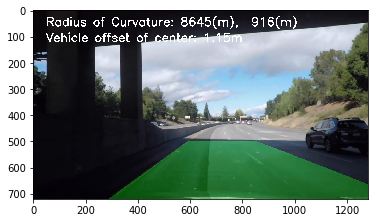

In [30]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('challenge_video.mp4')
lane = Lane()

img = clip.get_frame(4.6)
result = lane.draw_lane(img)

plt.imshow(result)

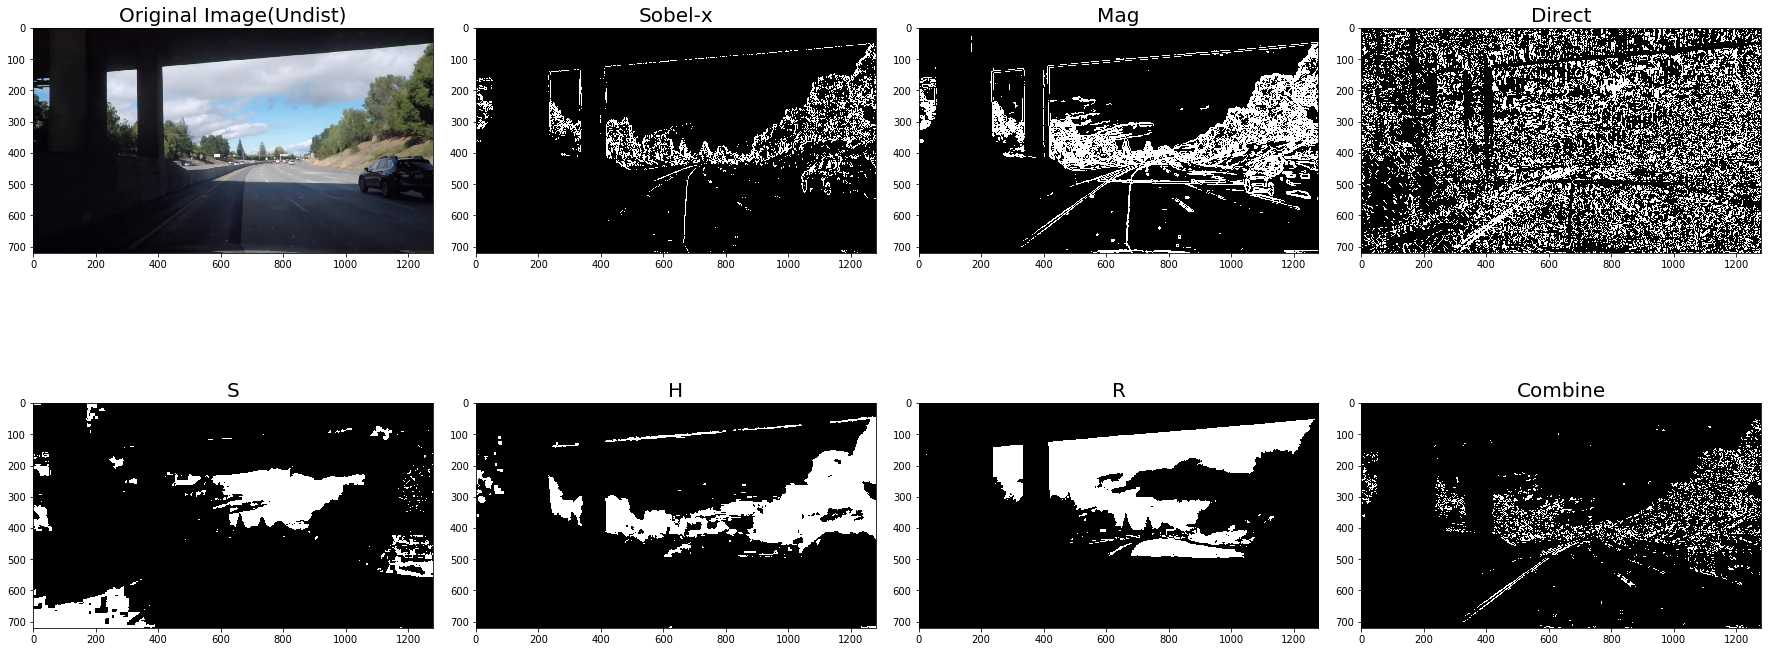

In [31]:
# Plot images utilities
def plot_images(imgs, titles, points=None):
    rows = len(imgs)
    cols = len(imgs[0])
    f, axs = plt.subplots(rows, cols, figsize=(24, 9))
    f.tight_layout()
    
    if rows == 1:
        for i in range(cols):
            axs[i].imshow(imgs[0][i], cmap='gray')
            axs[i].set_title(titles[0][i], fontsize=20)
            if points:
                axs[i].plot(points[0][i][:,0], points[0][i][:,1], 'r')
    else:
        for i in range(rows):
            for j in range(len(imgs[i])):
                axs[i][j].imshow(imgs[i][j], cmap='gray')
                axs[i][j].set_title(titles[i][j], fontsize=20)
                if points:
                    axs[i][j].plot(points[i][j][:,0], points[i][j][:,1], 'r')
    plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)
    
def S_channel(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def H_channel(img, thresh = (15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

    
clip = VideoFileClip('challenge_video.mp4')
lane = Lane()

t = clip.duration * 138./485. #4.6
img = clip.get_frame(t)
undist_img = lane.camera.undist(img)

R = lane.R_channel(undist_img, thresh=(170, 255))
sobelx = lane.sobel_xy(undist_img, thresh=(10, 100))
mag = lane.sobel_mag(undist_img, thresh=(10, 100))
dirt = lane.sobel_dir(undist_img, thresh=(0.7, 1.3))
S = S_channel(undist_img, thresh=(100, 255))
H = H_channel(undist_img, thresh=(15, 100))

com_img = np.zeros_like(R)
com_img[(mag == 1) & (dirt == 1)] = 1

plot_images([ [undist_img, sobelx, mag, dirt], [S, H, R, com_img] ], \
            [ ['Original Image(Undist)', 'Sobel-x', 'Mag', 'Direct'], [ 'S', 'H', 'R', 'Combine'] ])

0 0 640 0
[1279 1278  421  422  423  424  425  426  427  428  429  430  431  432  433
  434  435  436  437]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


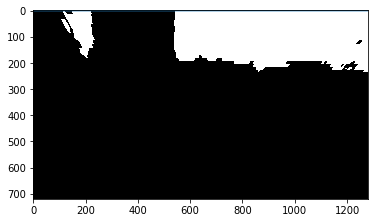

In [24]:
warped = lane.warp(com_img)
#plot_images([ [undist_img, com_img, warped] ], [ ['Original', 'Threshholded Image', 'Transformed Image'] ])
hist = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.imshow(warped, cmap='gray')
plt.plot(hist)

midpoint = np.int(hist.shape[0]/2)
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:1200]) + midpoint
print(leftx_base, hist[leftx_base], rightx_base, hist[rightx_base])

ids = np.argsort(hist)[-1:-20:-1]
vs = hist[ids]
print(ids)
print(vs)

==> Try R
==> Try Mag & Direct
====>__find_lane_0 Find: 20271 3934
==> Try R
====>__find_lane_1 Find: 9634 22084


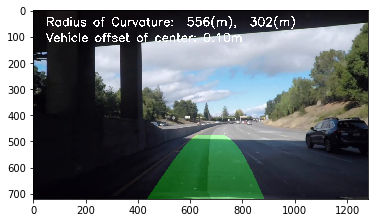

In [34]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('challenge_video.mp4')
lane = Lane()

#print('===>', 485. * 4.6 / clip.duration)
t = clip.duration * 137./485.
img = clip.get_frame(t)
result = lane.draw_lane(img)

t = clip.duration * 138./485.
img = clip.get_frame(t)
result = lane.draw_lane(img)

plt.imshow(result)

In [2]:
from moviepy.editor import VideoFileClip

lane = Lane()

video_output = 'challenge_output.mp4'
clip = VideoFileClip('challenge_video.mp4')

output_clip = clip.fl_image(lane.draw_lane)
%time output_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [04:05<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 4min 7s, sys: 4.73 s, total: 4min 11s
Wall time: 4min 5s
